Library imports

In [ ]:
!pip install pytorch-tabnet imbalanced-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score,
                             average_precision_score, confusion_matrix, roc_curve,
                             precision_recall_curve, precision_recall_fscore_support)
from imblearn.over_sampling import SMOTE

from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import os


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.4 MB/s eta 0:00:00


Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
pfad = '/content/drive/MyDrive/datasets/'
creditcard_df = pd.read_csv(pfad + 'creditcard.csv')
synthetic_df = pd.read_csv(pfad + 'fraudTest.csv')


Mounted at /content/drive


Dataset Exploration


 Data Info - PCAD Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-nu

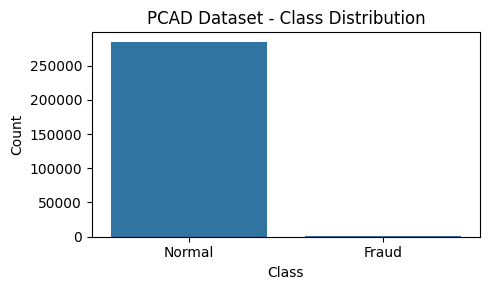

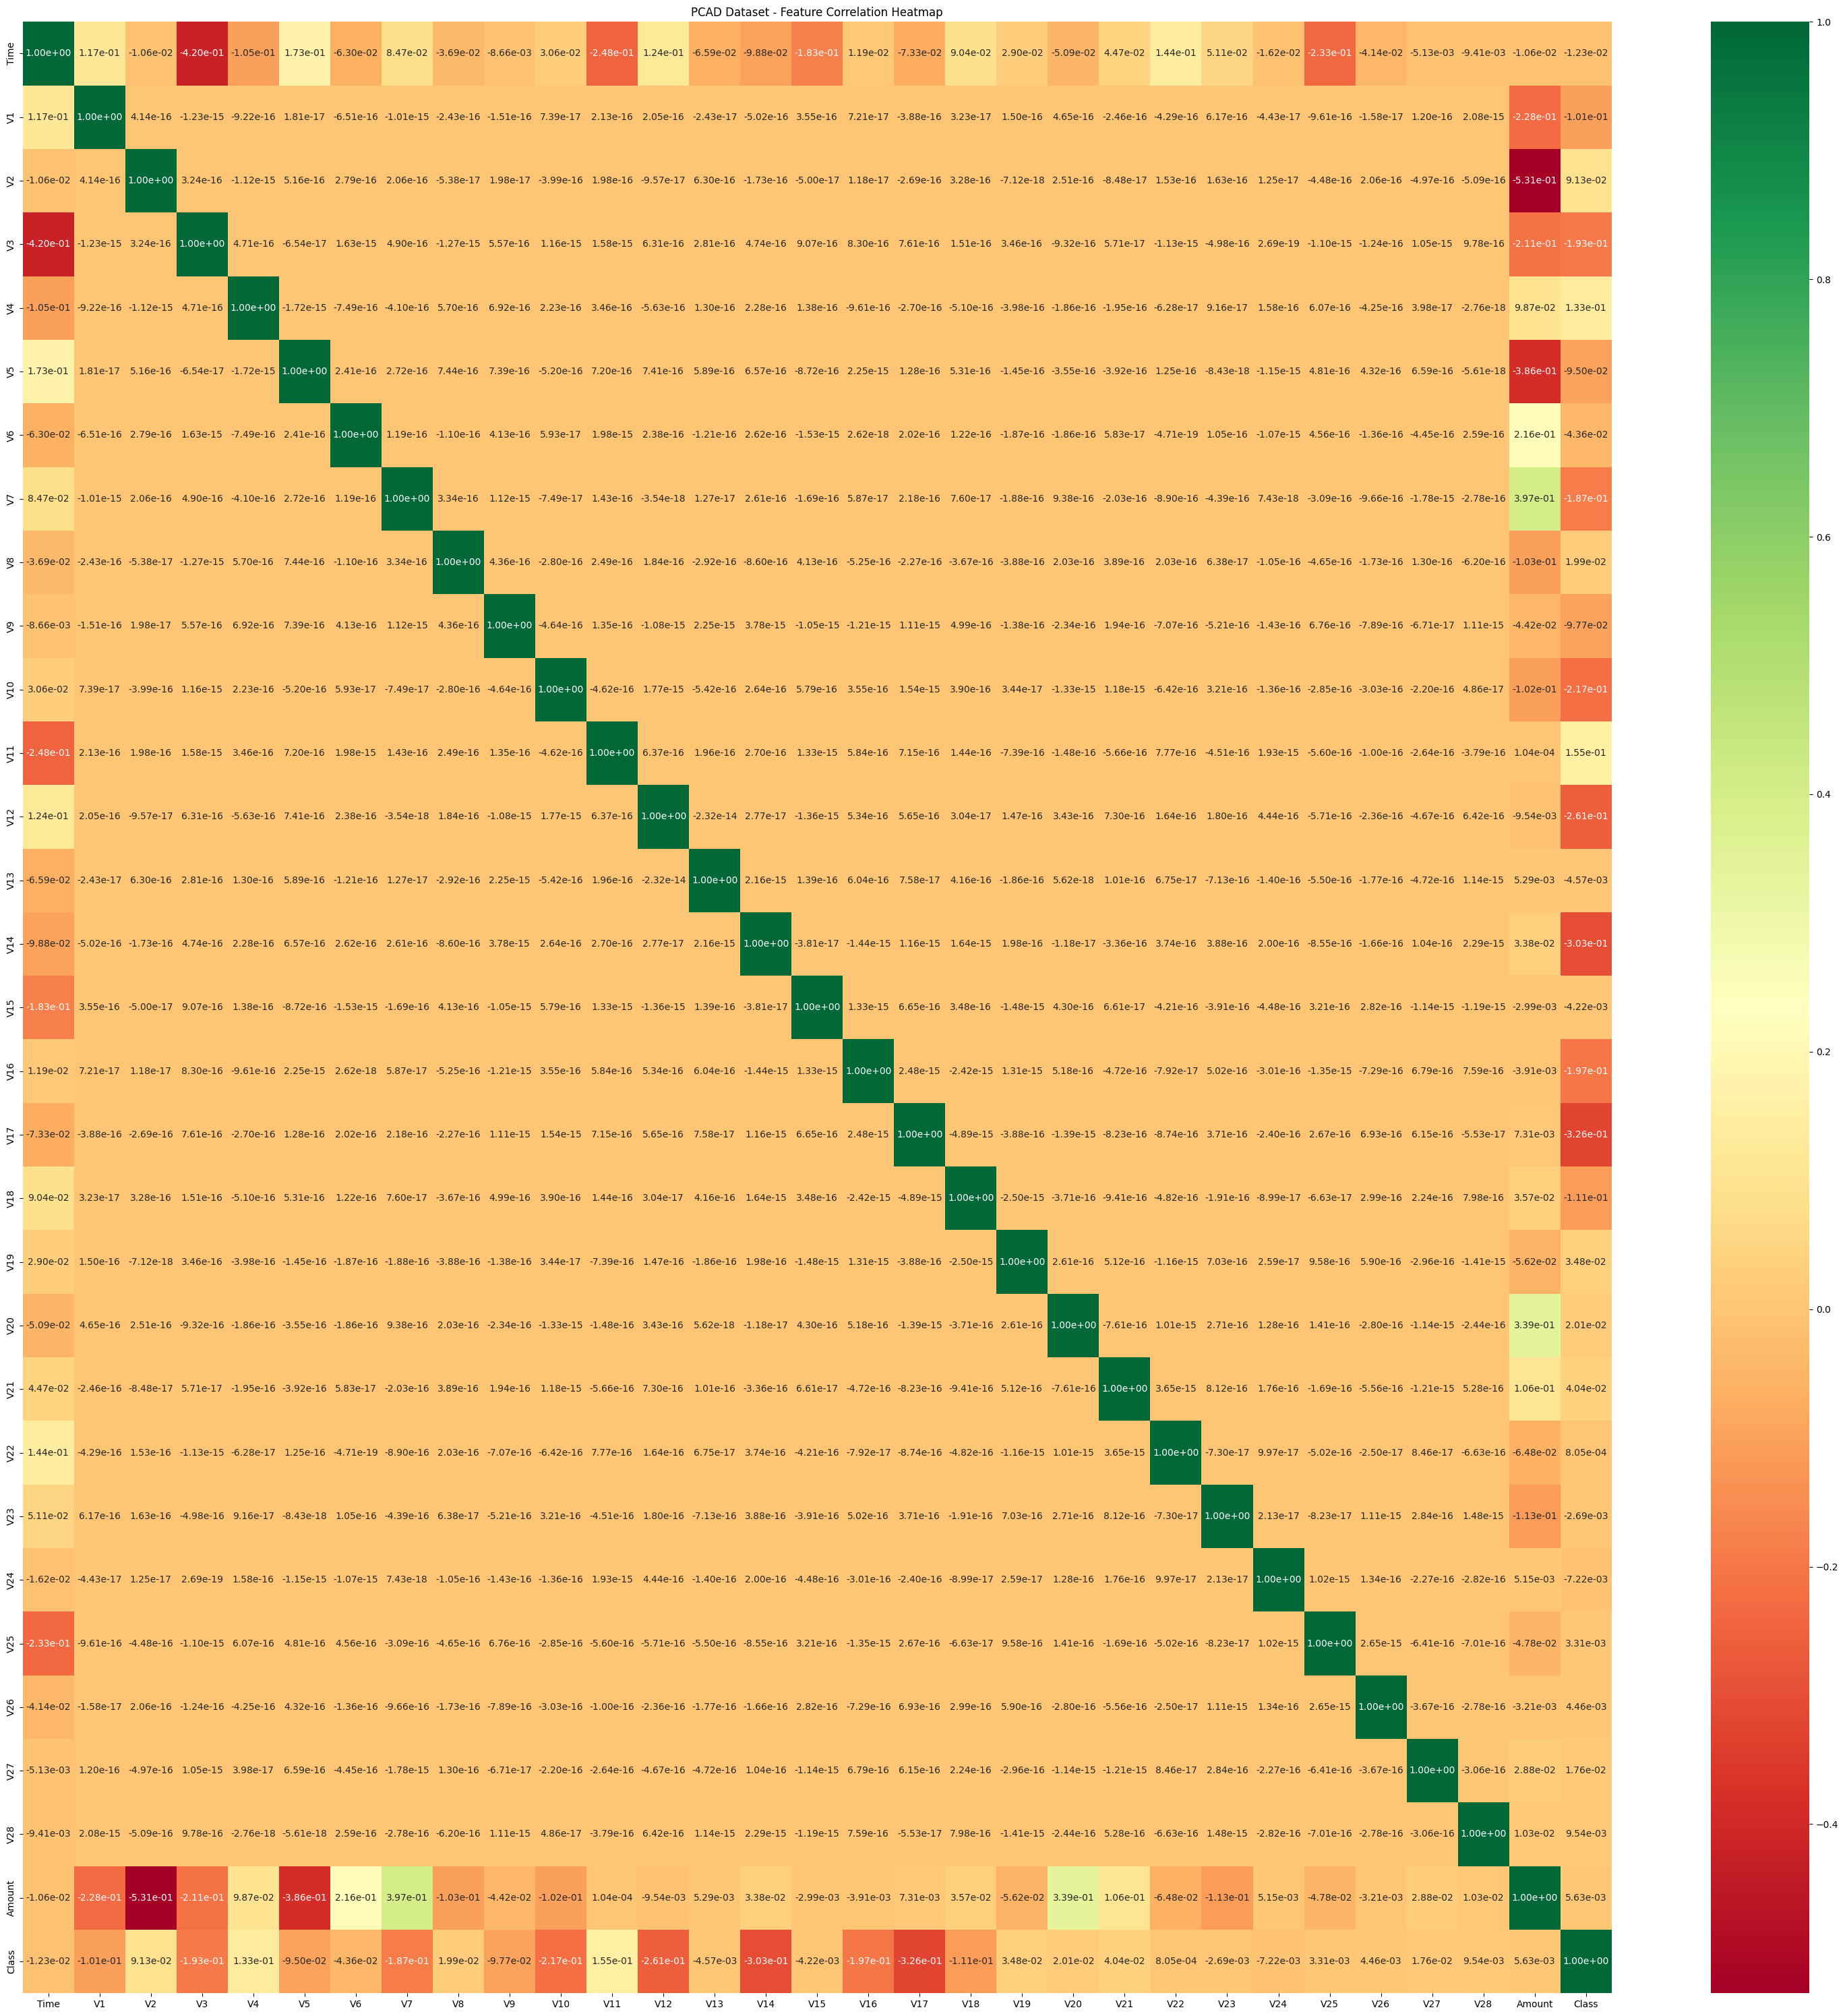


 Data Info - Synthetic Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long

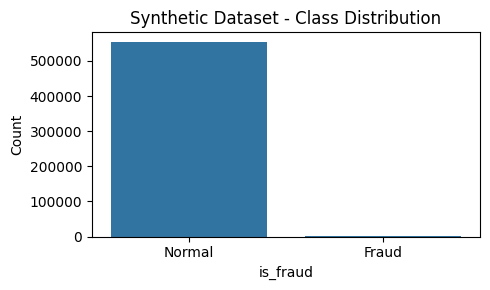

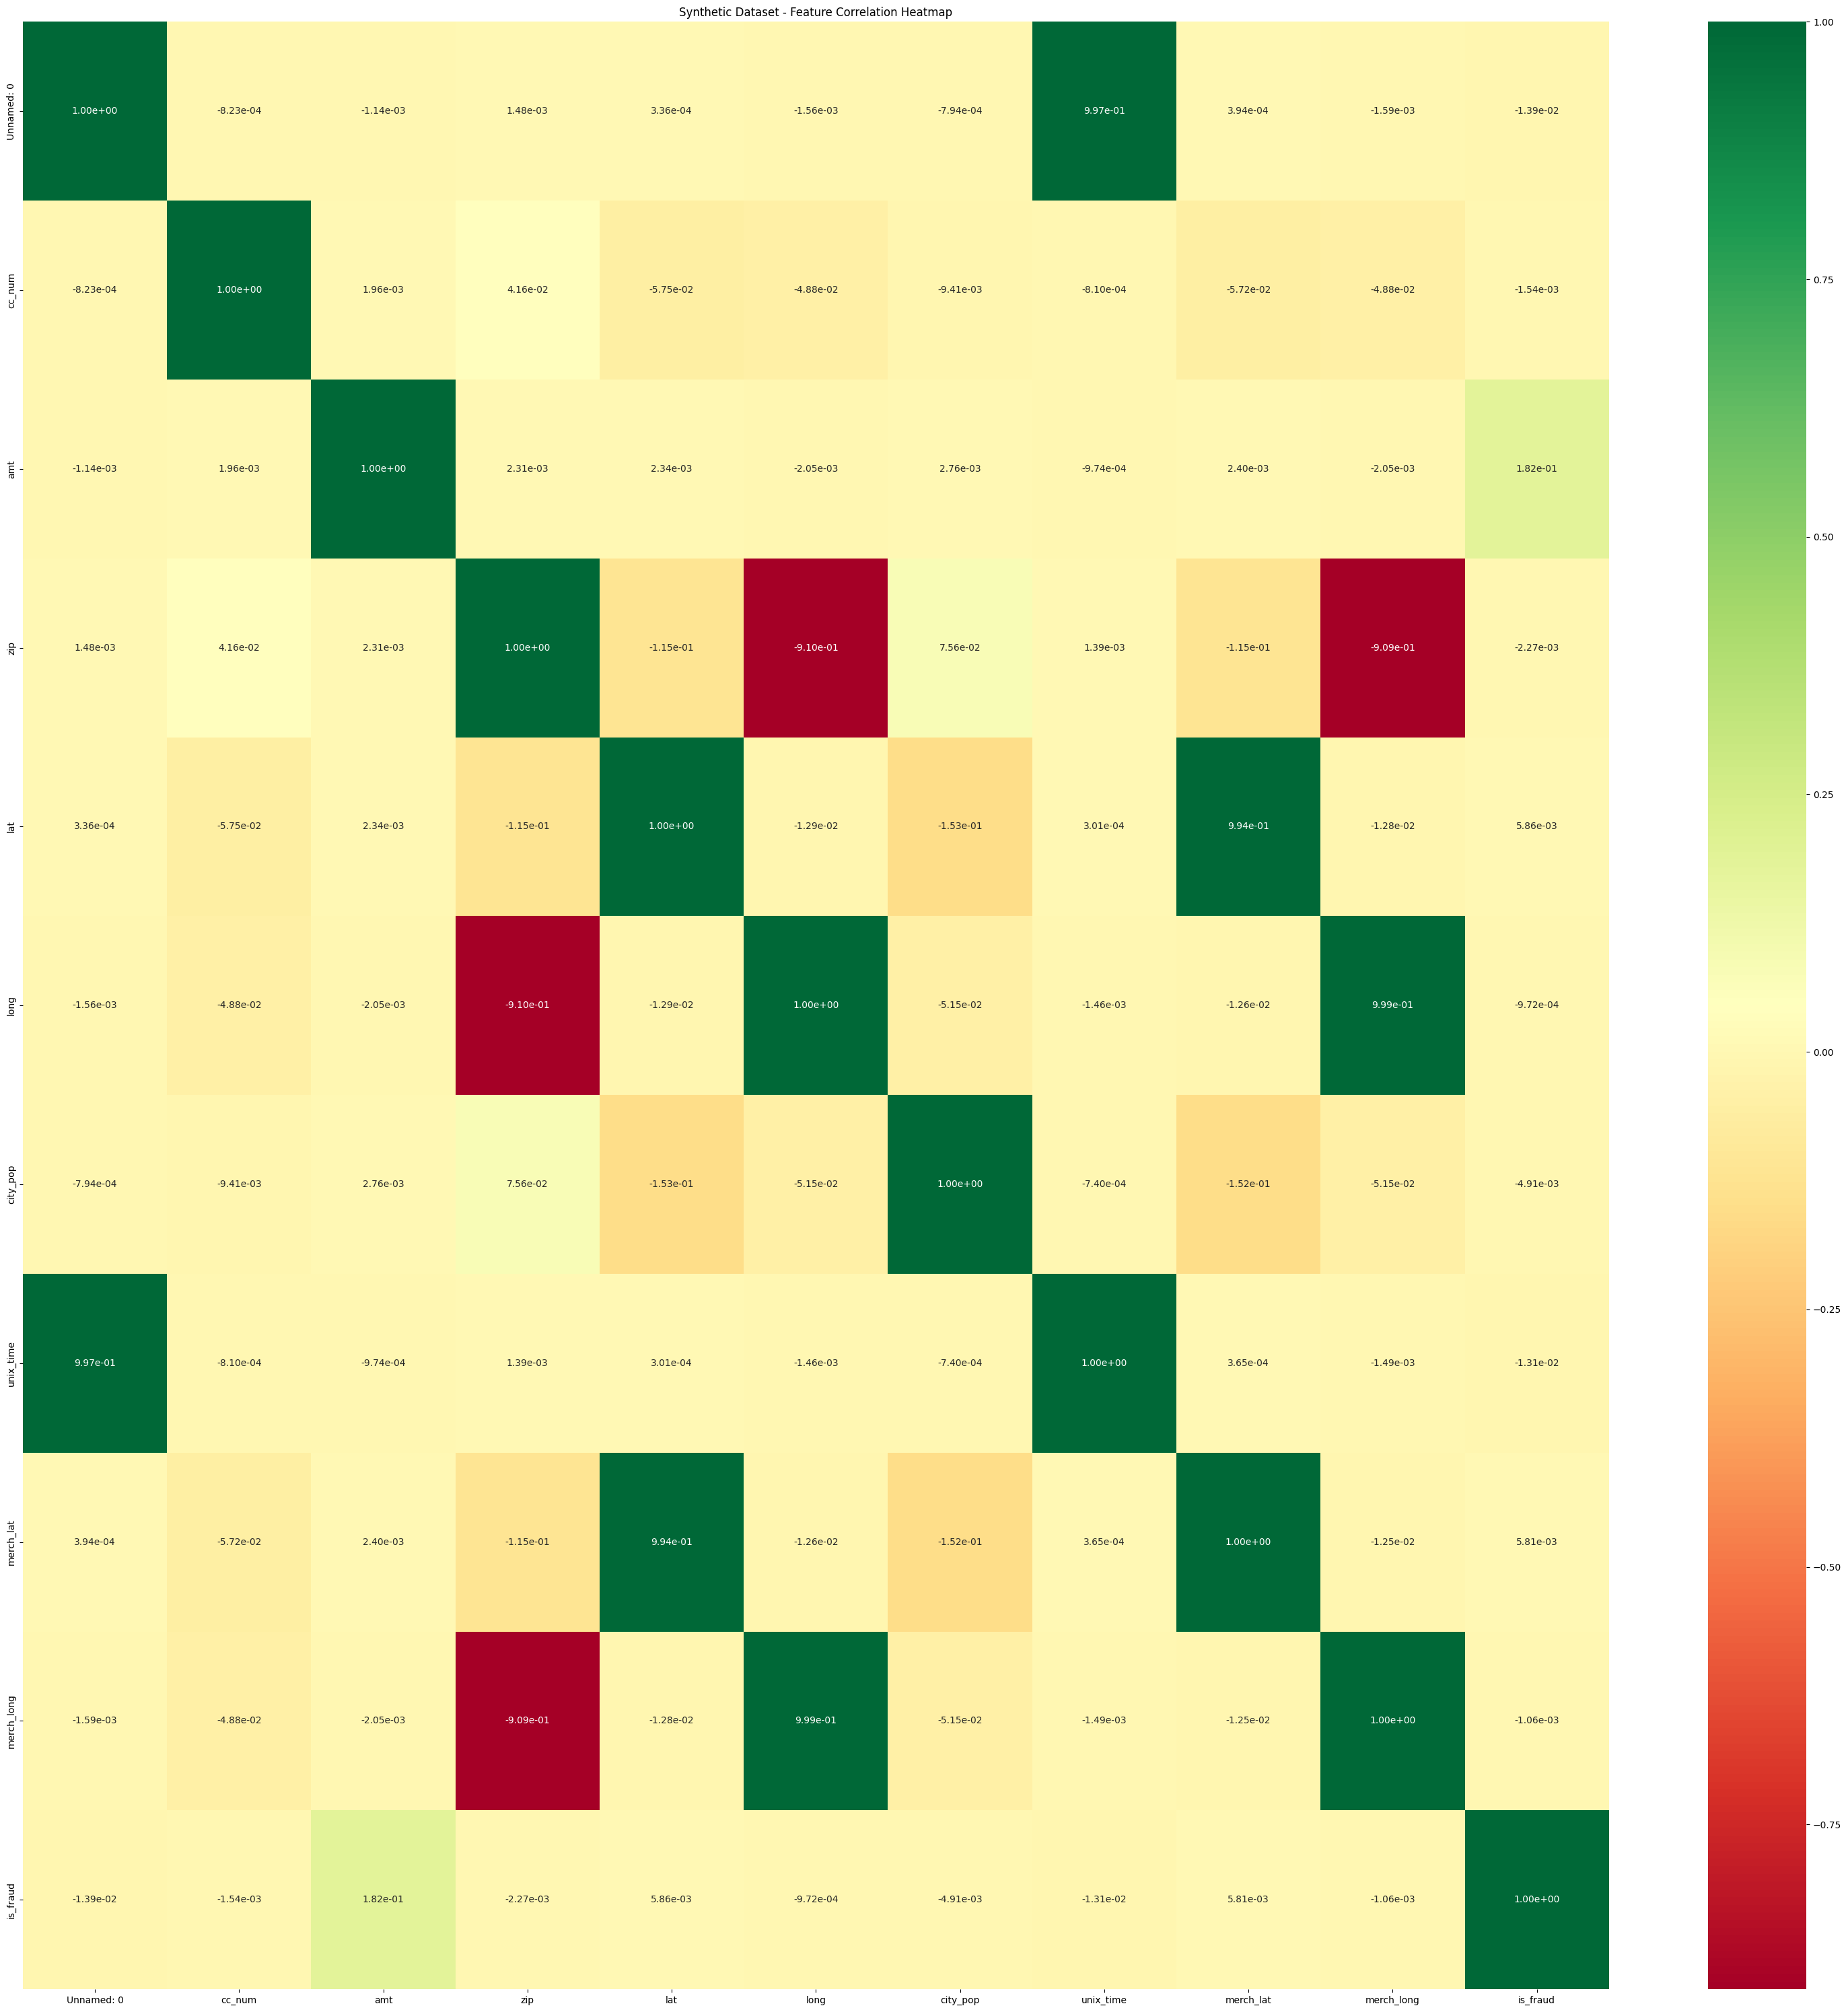

In [ ]:
def explore_data(df, title):
    print(f"\n Data Info - {title}")
    print(df.info())
    print("\nMissing values:", df.isnull().sum().sum())

    if 'Class' in df.columns:
        target_column = 'Class'
    elif 'is_fraud' in df.columns:
        target_column = 'is_fraud'
    else:
        raise ValueError("Target column not found in the dataset.")

    print("\nClass distribution:")
    print(df[target_column].value_counts())

    LABELS = ["Normal", "Fraud"]
    plt.figure(figsize=(5,3))
    sns.countplot(x=target_column, data=df)
    plt.title(f"{title} - Class Distribution")
    plt.xticks([0, 1], LABELS)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    numeric_df = df.select_dtypes(include=[np.number])

    if numeric_df.empty:
        print(f"No numeric data found in {title}. Skipping correlation heatmap.")
        return

    #  correlation matrix
    corr = numeric_df.corr()

    top_corr_features = corr.index


    plt.figure(figsize=(30,30))
    sns.heatmap(numeric_df[top_corr_features].corr(), annot=True, cmap="RdYlGn", fmt=".2e", cbar=True)
    plt.title(f"{title} - Feature Correlation Heatmap")
    plt.tight_layout()
    plt.show()


explore_data(creditcard_df, "PCAD Dataset")
explore_data(synthetic_df, "Synthetic Dataset")


Preprocess datasets seperately

In [ ]:
def preprocess(df, is_synthetic=False):
    if is_synthetic:
        df = df.rename(columns={df.columns[-1]: 'Class'})

        df = df.select_dtypes(include=[np.number]).copy()
    else:

        if 'Class' in df.columns:
            cols_to_keep = df.select_dtypes(include=[np.number]).columns.tolist()
            if 'Class' not in cols_to_keep:
                cols_to_keep.append('Class')
            df = df[cols_to_keep]

    X = df.drop('Class', axis=1)
    y = df['Class']

    if 'Time' in X.columns and 'Amount' in X.columns:
        scaler = StandardScaler()
        X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])
    return train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)



X_train_pcad, X_test_pcad, y_train_pcad, y_test_pcad = preprocess(creditcard_df)
print("PCAD shapes:", X_train_pcad.shape, y_train_pcad.shape)
X_train_syn, X_test_syn, y_train_syn, y_test_syn = preprocess(synthetic_df, is_synthetic=True)
print("Synthetic shapes:", X_train_syn.shape, y_train_syn.shape)


X_train_pcad, X_val_pcad, y_train_pcad, y_val_pcad = train_test_split(X_train_pcad, y_train_pcad, test_size=0.2, stratify=y_train_pcad, random_state=42)
X_train_syn, X_val_syn, y_train_syn, y_val_syn = train_test_split(X_train_syn, y_train_syn, test_size=0.2, stratify=y_train_syn, random_state=42)

PCAD shapes: (199364, 30) (199364,)
Synthetic shapes: (389003, 10) (389003,)


SMOTE

In [ ]:
def apply_smote(X_train, y_train):
  smote = SMOTE(random_state=42)
  X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
  print("Applied SMOTE. New shape: ",X_resampled.shape)
  return X_resampled,y_resampled

X_train_pcad, y_train_pcad = apply_smote(X_train_pcad, y_train_pcad)
X_train_syn, y_train_syn = apply_smote(X_train_syn, y_train_syn)


Applied SMOTE. New shape:  (318432, 30)
Applied SMOTE. New shape:  (620002, 10)


TabNet Training

kms

In [ ]:
def train_tabnet(X_train, y_train, X_val, y_val, X_test, y_test, label):
    clf = TabNetClassifier(verbose=1, seed=42)
    print("starting training...")

    clf.fit(X_train.values, y_train.values,
            eval_set=[(X_val.values, y_val.values)],
            eval_name=['val'],
            eval_metric=['accuracy'],
            max_epochs=50,
            patience=10,
            batch_size=128,
            virtual_batch_size=128)
    print("training done")


    print(f"\n {label} - Training Log (Epoch-wise):")
    losses = clf.history['loss']
    val_accuracies = clf.history['val_accuracy']

    for epoch, (loss, val_acc) in enumerate(zip(losses, val_accuracies), 1):
        print(f"Epoch {epoch:2d}: Loss = {loss:.4f} | Val Accuracy = {val_acc:.4f}")

    plt.figure(figsize=(8,4))
    plt.plot(losses, label='Train Loss')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel("Epochs")
    plt.title(f"{label} - Loss & Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    preds_proba = clf.predict_proba(X_test.values)[:, 1]
    preds = clf.predict(X_test.values)

    print(f"\n Evaluation Report - {label} Dataset")
    print(classification_report(y_test, preds))
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds))
    print("Recall:", recall_score(y_test, preds))
    print("F1 Score:", f1_score(y_test, preds))

    roc_auc = roc_auc_score(y_test, preds_proba)
    pr_auc = average_precision_score(y_test, preds_proba)
    print(f"ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")

    # confusion matrix
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{label} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, preds_proba)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{label} - ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # PR curve
    prec, rec, _ = precision_recall_curve(y_test, preds_proba)
    plt.plot(rec, prec, label=f'{label} (PR-AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{label} - Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Evaluation

run for both of the datasets

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


starting training...
epoch 0  | loss: 0.07355 | val_accuracy: 0.98932 |  0:01:05s
epoch 1  | loss: 0.03076 | val_accuracy: 0.99398 |  0:02:12s
epoch 2  | loss: 0.0226  | val_accuracy: 0.99586 |  0:03:17s
epoch 3  | loss: 0.016   | val_accuracy: 0.98074 |  0:04:20s
epoch 4  | loss: 0.01534 | val_accuracy: 0.99243 |  0:05:23s
epoch 5  | loss: 0.0152  | val_accuracy: 0.99431 |  0:06:29s
epoch 6  | loss: 0.01227 | val_accuracy: 0.99566 |  0:07:35s
epoch 7  | loss: 0.0108  | val_accuracy: 0.99689 |  0:08:38s
epoch 8  | loss: 0.00978 | val_accuracy: 0.99551 |  0:09:41s
epoch 9  | loss: 0.00947 | val_accuracy: 0.99561 |  0:10:48s
epoch 10 | loss: 0.00933 | val_accuracy: 0.99599 |  0:11:51s
epoch 11 | loss: 0.00845 | val_accuracy: 0.99265 |  0:12:57s
epoch 12 | loss: 0.00789 | val_accuracy: 0.99717 |  0:13:59s
epoch 13 | loss: 0.0078  | val_accuracy: 0.99719 |  0:15:00s
epoch 14 | loss: 0.00792 | val_accuracy: 0.99762 |  0:16:03s
epoch 15 | loss: 0.00745 | val_accuracy: 0.99797 |  0:17:10s
epo

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training done

 PCAD - Training Log (Epoch-wise):
Epoch  1: Loss = 0.0735 | Val Accuracy = 0.9893
Epoch  2: Loss = 0.0308 | Val Accuracy = 0.9940
Epoch  3: Loss = 0.0226 | Val Accuracy = 0.9959
Epoch  4: Loss = 0.0160 | Val Accuracy = 0.9807
Epoch  5: Loss = 0.0153 | Val Accuracy = 0.9924
Epoch  6: Loss = 0.0152 | Val Accuracy = 0.9943
Epoch  7: Loss = 0.0123 | Val Accuracy = 0.9957
Epoch  8: Loss = 0.0108 | Val Accuracy = 0.9969
Epoch  9: Loss = 0.0098 | Val Accuracy = 0.9955
Epoch 10: Loss = 0.0095 | Val Accuracy = 0.9956
Epoch 11: Loss = 0.0093 | Val Accuracy = 0.9960
Epoch 12: Loss = 0.0084 | Val Accuracy = 0.9927
Epoch 13: Loss = 0.0079 | Val Accuracy = 0.9972
Epoch 14: Loss = 0.0078 | Val Accuracy = 0.9972
Epoch 15: Loss = 0.0079 | Val Accuracy = 0.9976
Epoch 16: Loss = 0.0075 | Val Accuracy = 0.9980
Epoch 17: Loss = 0.0073 | Val Accuracy = 0.9985
Epoch 18: Loss = 0.0066 | Val Accuracy = 0.9981
Epoch 19: Loss = 0.0073 | Val Accuracy = 0.9995
Epoch 20: Loss = 0.0062 | Val Accuracy

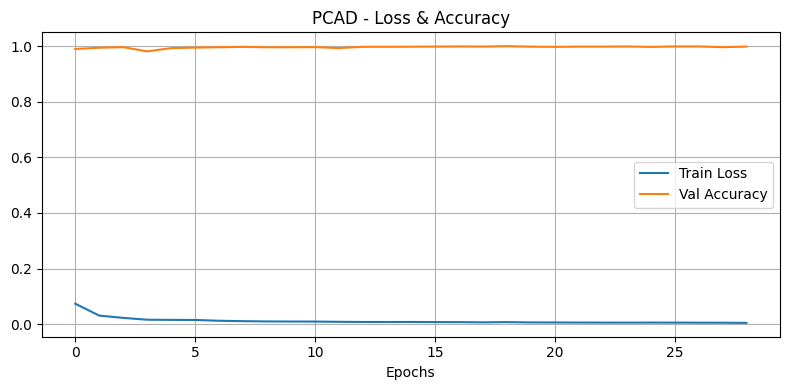


📊 Evaluation Report - PCAD Dataset
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.76      0.72      0.74       148

    accuracy                           1.00     85443
   macro avg       0.88      0.86      0.87     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy: 0.999133925541004
Precision: 0.7642857142857142
Recall: 0.722972972972973
F1 Score: 0.7430555555555556
ROC-AUC: 0.9384, PR-AUC: 0.7573


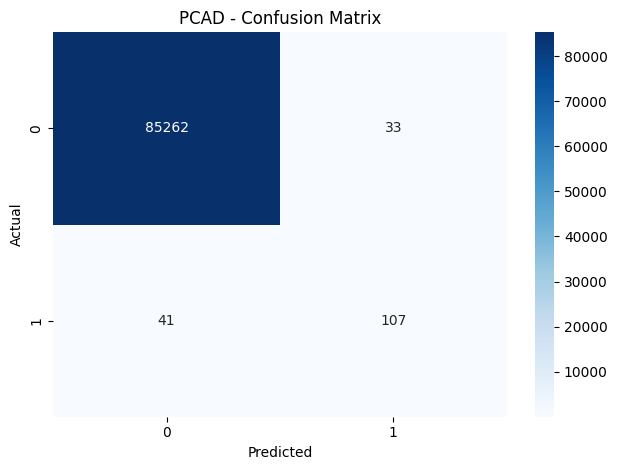

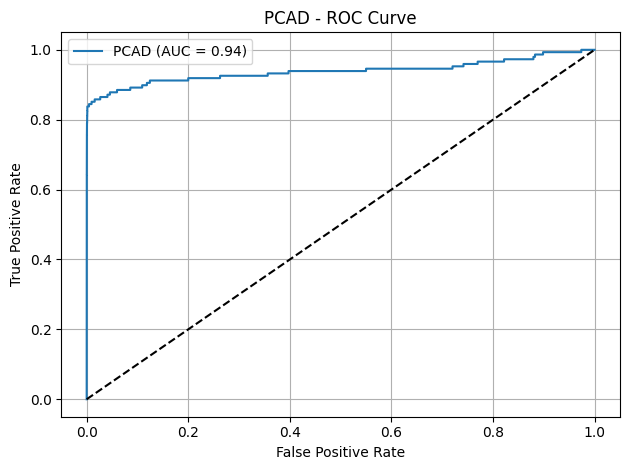

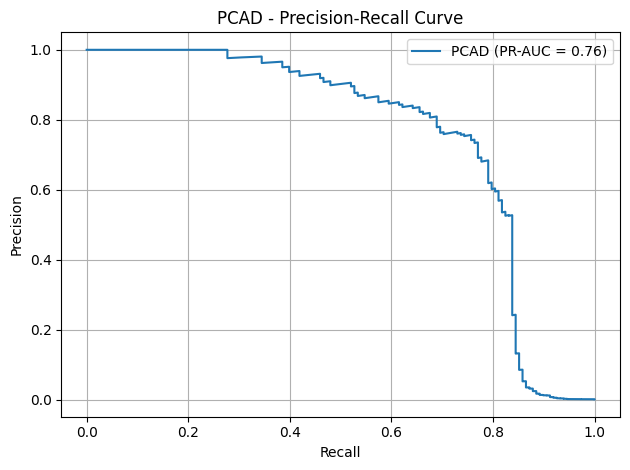

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


starting training...
epoch 0  | loss: 0.2904  | val_accuracy: 0.09051 |  0:02:00s
epoch 1  | loss: 0.24699 | val_accuracy: 0.928   |  0:04:00s
epoch 2  | loss: 0.21795 | val_accuracy: 0.96775 |  0:05:58s
epoch 3  | loss: 0.2037  | val_accuracy: 0.97389 |  0:07:58s
epoch 4  | loss: 0.19003 | val_accuracy: 0.96075 |  0:09:58s
epoch 5  | loss: 0.18284 | val_accuracy: 0.9671  |  0:11:54s
epoch 6  | loss: 0.17912 | val_accuracy: 0.92297 |  0:13:57s
epoch 7  | loss: 0.17646 | val_accuracy: 0.87933 |  0:15:57s
epoch 8  | loss: 0.17306 | val_accuracy: 0.82108 |  0:17:54s
epoch 9  | loss: 0.17021 | val_accuracy: 0.88301 |  0:19:55s
epoch 10 | loss: 0.16799 | val_accuracy: 0.90009 |  0:21:58s
epoch 11 | loss: 0.16649 | val_accuracy: 0.99198 |  0:23:59s
epoch 12 | loss: 0.16554 | val_accuracy: 0.80936 |  0:25:59s
epoch 13 | loss: 0.16442 | val_accuracy: 0.98481 |  0:27:55s
epoch 14 | loss: 0.16164 | val_accuracy: 0.96368 |  0:29:57s
epoch 15 | loss: 0.16044 | val_accuracy: 0.28542 |  0:31:56s
epo

In [ ]:
train_tabnet(X_train_pcad, y_train_pcad, X_val_pcad, y_val_pcad, X_test_pcad, y_test_pcad, label="PCAD")

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


starting training...
epoch 0  | loss: 0.2904  | val_accuracy: 0.09051 |  0:02:00s
epoch 1  | loss: 0.24699 | val_accuracy: 0.928   |  0:04:04s
epoch 2  | loss: 0.21795 | val_accuracy: 0.96775 |  0:06:07s
epoch 3  | loss: 0.2037  | val_accuracy: 0.97389 |  0:08:08s
epoch 4  | loss: 0.19003 | val_accuracy: 0.96075 |  0:10:08s
epoch 5  | loss: 0.18284 | val_accuracy: 0.9671  |  0:12:08s
epoch 6  | loss: 0.17912 | val_accuracy: 0.92297 |  0:14:07s
epoch 7  | loss: 0.17646 | val_accuracy: 0.87933 |  0:16:10s
epoch 8  | loss: 0.17306 | val_accuracy: 0.82108 |  0:18:11s
epoch 9  | loss: 0.17021 | val_accuracy: 0.88301 |  0:20:10s
epoch 10 | loss: 0.16799 | val_accuracy: 0.90009 |  0:22:11s
epoch 11 | loss: 0.16649 | val_accuracy: 0.99198 |  0:24:11s
epoch 12 | loss: 0.16554 | val_accuracy: 0.80936 |  0:26:13s
epoch 13 | loss: 0.16442 | val_accuracy: 0.98481 |  0:28:14s
epoch 14 | loss: 0.16164 | val_accuracy: 0.96368 |  0:30:12s
epoch 15 | loss: 0.16044 | val_accuracy: 0.28542 |  0:32:14s
epo

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training done

 Synthetic - Training Log (Epoch-wise):
Epoch  1: Loss = 0.2904 | Val Accuracy = 0.0905
Epoch  2: Loss = 0.2470 | Val Accuracy = 0.9280
Epoch  3: Loss = 0.2179 | Val Accuracy = 0.9678
Epoch  4: Loss = 0.2037 | Val Accuracy = 0.9739
Epoch  5: Loss = 0.1900 | Val Accuracy = 0.9607
Epoch  6: Loss = 0.1828 | Val Accuracy = 0.9671
Epoch  7: Loss = 0.1791 | Val Accuracy = 0.9230
Epoch  8: Loss = 0.1765 | Val Accuracy = 0.8793
Epoch  9: Loss = 0.1731 | Val Accuracy = 0.8211
Epoch 10: Loss = 0.1702 | Val Accuracy = 0.8830
Epoch 11: Loss = 0.1680 | Val Accuracy = 0.9001
Epoch 12: Loss = 0.1665 | Val Accuracy = 0.9920
Epoch 13: Loss = 0.1655 | Val Accuracy = 0.8094
Epoch 14: Loss = 0.1644 | Val Accuracy = 0.9848
Epoch 15: Loss = 0.1616 | Val Accuracy = 0.9637
Epoch 16: Loss = 0.1604 | Val Accuracy = 0.2854
Epoch 17: Loss = 0.1593 | Val Accuracy = 0.9033
Epoch 18: Loss = 0.1586 | Val Accuracy = 0.4052
Epoch 19: Loss = 0.1587 | Val Accuracy = 0.9454
Epoch 20: Loss = 0.1563 | Val Acc

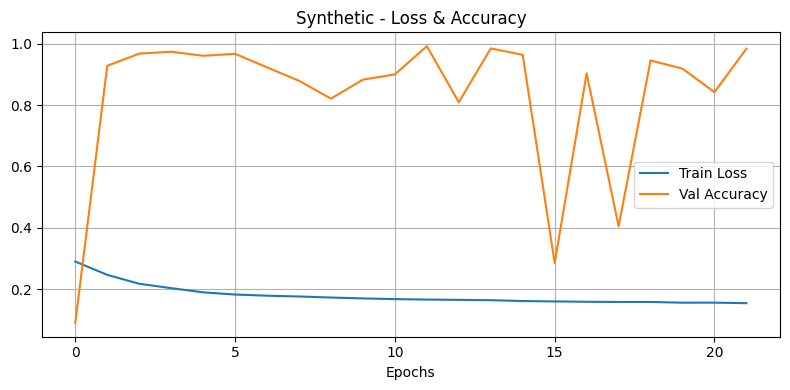


📊 Evaluation Report - Synthetic Dataset
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    166072
           1       0.24      0.55      0.33       644

    accuracy                           0.99    166716
   macro avg       0.62      0.77      0.66    166716
weighted avg       1.00      0.99      0.99    166716

Accuracy: 0.9915724945416157
Precision: 0.23991797676008203
Recall: 0.5450310559006211
F1 Score: 0.3331751305173232
ROC-AUC: 0.9326, PR-AUC: 0.3297


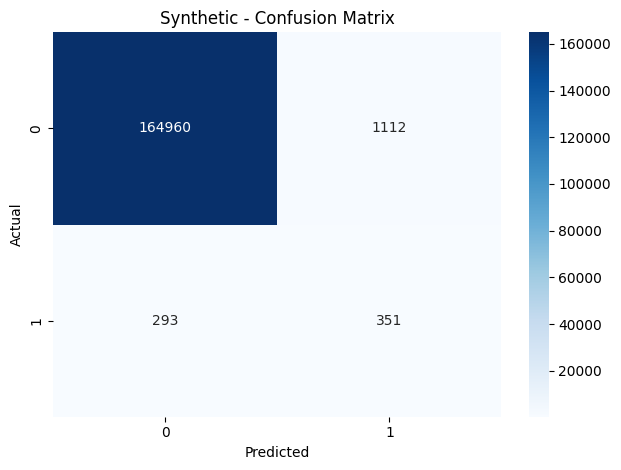

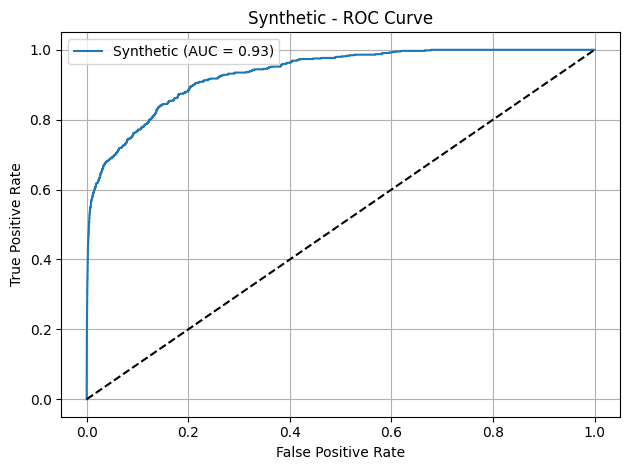

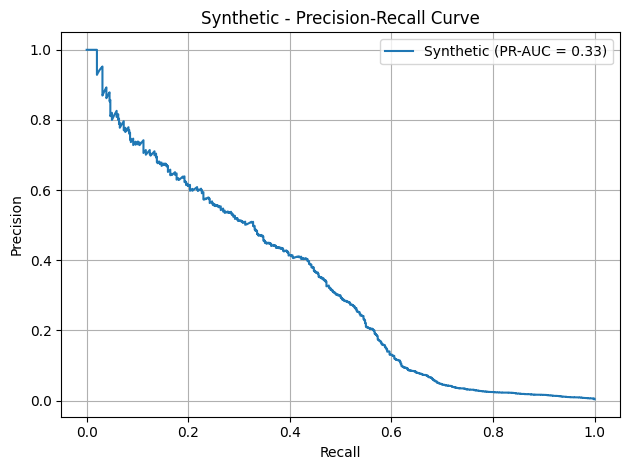

In [ ]:
train_tabnet(X_train_syn, y_train_syn, X_val_syn, y_val_syn, X_test_syn, y_test_syn, label="Synthetic")
